<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Session11_Superconvergence/main_with_OneCyclePolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setting up environment

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
cd '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/Session7_CIFAR/cnn_for_cifar10/'

/gdrive/My Drive/Colab Notebooks/SchoolOfAI/Session7_CIFAR/cnn_for_cifar10


In [3]:
ls

data/                        models/
gradcam/                     __pycache__/
grad_cam_missclassified.jpg  run_results/
lr_finder/                   Scripts/
mainfile.py                  test.py
main.ipynb                   train.py
main_with_LRFinder.ipynb     transform_albumentation.py
metrics/                     transform.py


##Import libraries

In [4]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-braxopv2
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-braxopv2
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=772dc2b385abede1b8be1bf5b8ba058fb1ae89a0d258799a2e6dd3e1fc8a49f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-npu901xn/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


## Import modules

In [5]:
#To reload custom modules
import autoreload
# %load_ext autoreload
%reload_ext autoreload
%autoreload

#import all necessary .py files
from train import train
from test import test


# Torchvision transforms
#from transform import transform

# Albumentations transform
from transform_albumentation import transform
# Residing place of DNN models
from models import *
# For graphs and incorrect image sample
from metrics import metrics, image_utilities

# Gradient Class Activation mapping
from gradcam import gradcam, gradcampp, utils
# To find the optimum learning rate
from lr_finder import LRFinder

Albumentations version: 0.4.5
Resnet18 model


## Model setup and summary

In [6]:
#Check the number of parameters
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
#My model
#net = Net().to(device)

#Resnet18 model
# net = ResNet18().to(device)

# Mixed Resnet model
net = MixedResNet9().to(device)
summary(net, input_size=(3, 32, 32))

cuda
MixedResnet model is now loaded.
Conv + Maxpool + BN + Relu every layer. Resnet blocks every alternate layer- 1st and 3rd layers.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-

## Triangular Learning policy

Triangular learning rate policy across iterations.

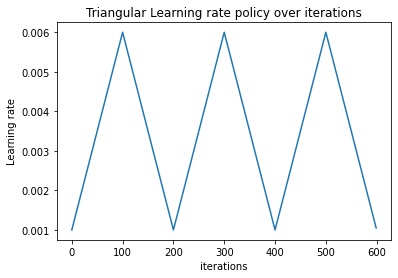

In [7]:
 def triangular_LR():
    iterations = 0 # Iterations completed
    t_step_size = 100 # No of steps to go from min to max. Equal to one half of cycle
    base_lr=0.001
    max_lr=0.006
    max_iter = 600 # Maximum number of iterations planned

    f = []
    for iterations in range(max_iter):
        cycle = np.floor(1 + iterations/(2*t_step_size)) # Tells which cycle are you currently in
        x = np.abs((iterations/t_step_size)-(2*cycle)+1)
        f.append(base_lr + (max_lr - base_lr)* (1-x))
    plt.plot(f)
    plt.xlabel("iterations")
    plt.ylabel("Learning rate")
    plt.title("Triangular Learning rate policy over iterations")

triangular_LR()

##Display transformed training data.##
Call transform function to set the dataloaders.
Display examples of augmented training dataset.

Batchsize used = 512

Image transformation applied-
1) Padding of the image by on all sides. Total image size=40

2) Random crop of 32 X 32 from the padded image.

3) Horizontal flip of the image.

4) Cutout of size 8 X 8 applied on the image.

Files already downloaded and verified
Files already downloaded and verified
Train set
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Test set
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


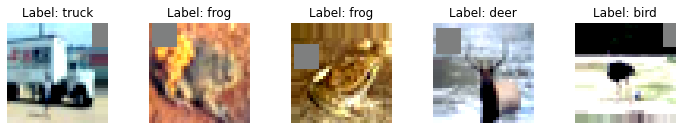

In [7]:
trainloader, testloader, classes = transform(512)
#Display the transformed training data.
image_display_size = 5
dataiter = iter(trainloader)
disp_images, disp_labels = dataiter.next()

# imshow(disp_images[0])
# print(disp_images[0].shape)
fig, axs = plt.subplots(1, 5, figsize=(10, 10))
fig.tight_layout()

for i in range(image_display_size):
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[disp_labels[i]]}')
    axs[i].imshow(np.transpose(((disp_images[i]/2 + 0.5).numpy()), (1, 2, 0)))

##Find the optimum Learning rate using LRFinder.
This is to determine the minimum and maximum LR boundaries. 
1. start_lr=0.0001 and end_lr=1.0 (exp): Steep decrease in loss observed between 0.01 and 0.05
2. start_lr = 0.01 and end_lr=0.1 (exp): Best loss observed at 0.03


Files already downloaded and verified
Files already downloaded and verified
Train set
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Test set
Files already downloaded and verified



Learning rate search finished. See the graph with {finder_name}.plot()
Best Loss observed at LR= 0.0381475


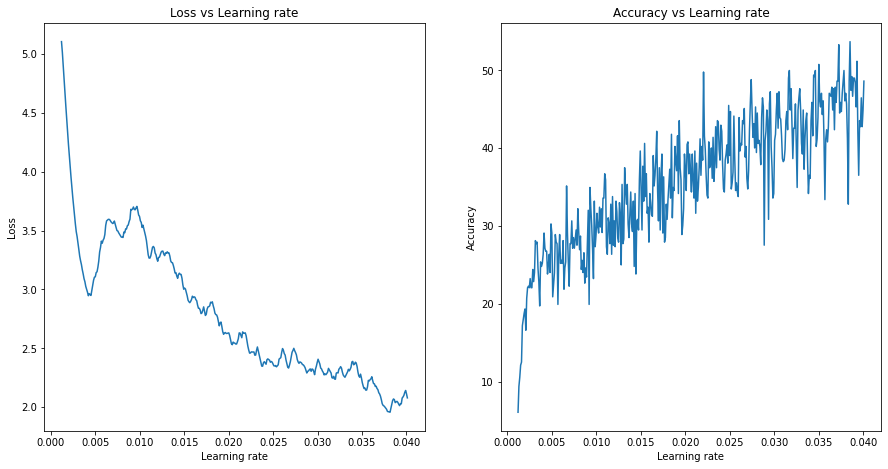

In [7]:
trainloader, testloader, classes = transform(512)
criterion = nn.CrossEntropyLoss()
# Optimum LR for custom_model = 0.015
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=0.001)
lr_finder = LRFinder(net, optimizer, criterion, device)
#Run the range test
lr_finder.range_test(trainloader, end_lr=0.04, num_iter=400, step_mode="linear")
print("Best Loss observed at LR=",lr_finder.history['lr'][lr_finder.history['Loss'].index(lr_finder.best_loss)])
lr_finder.plot(skip_start=0, skip_end=0, log_lr=False)
lr_finder.reset()

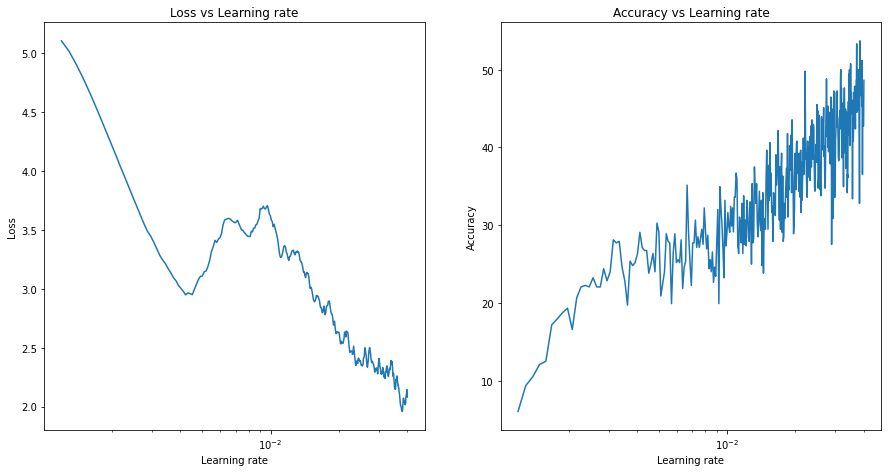

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f857cb1bf28>,
      dtype=object)

In [8]:
lr_finder.plot(skip_start=0, skip_end=0, log_lr=True)

## Model training and validation

In [7]:
EPOCHS =24
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
from torch.optim.lr_scheduler import OneCycleLR 
#import CIFAR10 data. Perform Normalize, Batching through transforms.
trainloader, testloader, classes = transform(512)
criterion = nn.CrossEntropyLoss()
# Optimum LR for custom_model = 0.015, 0.04 for resnet
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

#One Cycle Policy requires scheduler update after every batch. Hence, passing the scheduler to the train function to update after every batch.
scheduler = OneCycleLR(optimizer, max_lr=0.038, total_steps=None, epochs=EPOCHS, steps_per_epoch=len(trainloader), pct_start=5/EPOCHS, anneal_strategy='linear', cycle_momentum=True, 
                       base_momentum=0.85, max_momentum=0.95, div_factor=10, final_div_factor=1, last_epoch=-1)

for epoch in range(EPOCHS):
  print("epoch:", epoch)
  train_accuracy_delta, train_loss_delta = train(net, device, trainloader, optimizer, criterion, epoch, scheduler)
  test_accuracy_delta, test_loss_delta = test(net, device, testloader, criterion)
  
  train_accuracy.append(train_accuracy_delta)
  train_loss.append(train_loss_delta)
  test_accuracy.append(test_accuracy_delta)
  test_loss.append(test_loss_delta)
  
print("Train Accuracy-",train_accuracy)
print("Test Accuracy-",test_accuracy)

print("Train loss-",train_loss)
print("Test loss-",test_loss)


Files already downloaded and verified
Files already downloaded and verified
Train set
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Test set
Files already downloaded and verified
epoch: 0
Epoch Train loss: 3.851441474304986         Epoch Train Accuracy: 20.034
Epoch Test loss: 2.161846971511841         Epoch Test Accuracy: 23.49
epoch: 1
Epoch Train loss: 2.050108593763764         Epoch Train Accuracy: 34.17
Epoch Test loss: 1.735784775018692         Epoch Test Accuracy: 41.08
epoch: 2
Epoch Train loss: 1.5845474434882094         Epoch Train Accuracy: 47.236
Epoch Test loss: 1.5009165287017823         Epoch Test Accuracy: 46.25
epoch: 3
Epoch Train loss: 1.1920024598996664         Epoch Train Accuracy: 59.202
Epoch Test loss: 1.097160542011261         Epoch Test Accuracy: 59.79
epoch: 4
Epoch Train loss: 0.8903520439088959         Epoch Train Accuracy: 68.878
Epoch Test loss: 0.8968108236789704         Epoch Test Accur

##Loss and accuracy trend versus epoch for train and test##

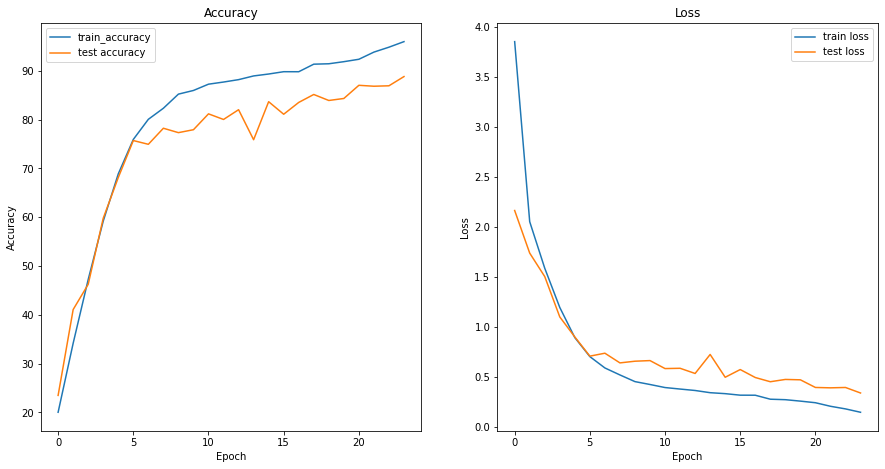

In [8]:
metrics.train_test_metrics_graph(train_accuracy, train_loss, test_accuracy, test_loss)

##To check Class activation mapping for misclassified images##

In [0]:
# Capture images, labels and predictions for misclassified samples
incorrect_labels, incorrect_predictions, incorrect_images = image_utilities.capture_correct_incorrect_classified_samples(net, device, testloader)

#Calculate mean and standard deviation of the dataset for denormalization.
stddev, means = image_utilities.dataset_calculate_mean_std()
print("Mean:", means)
print("Std Deviation:", stddev)

Files already downloaded and verified
Files already downloaded and verified
Mean: [0.4918687788500817, 0.4826539051649305, 0.44717727749693625]
Std Deviation: [0.24697121432552785, 0.24338893940435022, 0.2615925905215076]


In [0]:
cam_dict = dict()

resnet_model_dict = dict(type='resnet', arch=net, layer_name='layer4', input_size=(32, 32))
resnet_gradcam = gradcam.GradCAM(resnet_model_dict, True)
#gradcam needs normalized image. Image from capture image function is normalized.
incorrect_images = incorrect_images.to(device)

saliency_map size : torch.Size([4, 4])


Display misclassified image's class activation

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


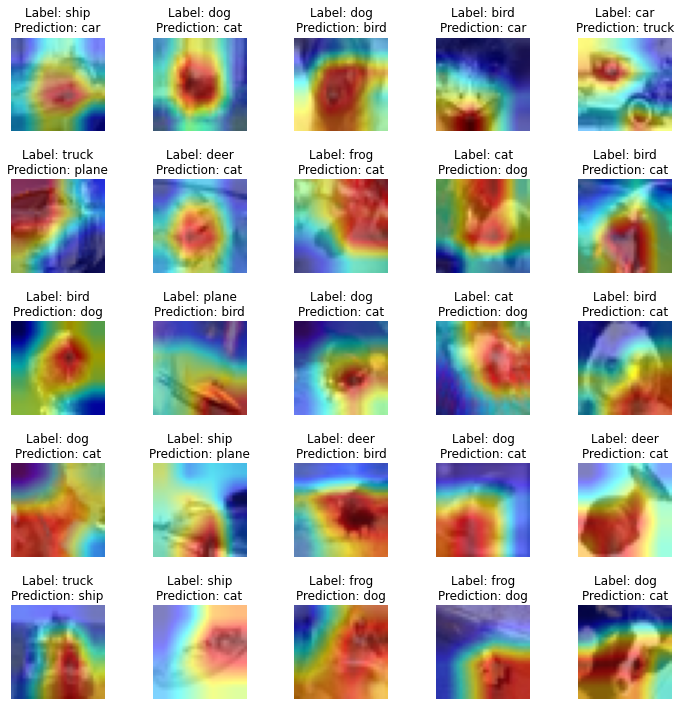

In [0]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.tight_layout()
i = 0
nrows = 5
ncols = 5
for row in range(nrows):
    for col in range(ncols):
        mask, _ = resnet_gradcam(incorrect_images[i].unsqueeze(dim=0))
        normal_image = utils.denormalize(incorrect_images[i].unsqueeze(dim=0),means,stddev)
        heatmap, result = utils.visualize_cam(mask.cpu(), normal_image)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Label: {classes[incorrect_labels[i]]}\nPrediction: {classes[incorrect_predictions[i]]}')
        axs[row, col].imshow(np.transpose((result.numpy()), (1, 2, 0)))
        i += 1
fig.savefig("run_results/grad_cam_missclassified.jpg", bbox_inches='tight')    

Display the raw image of the misclassified images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

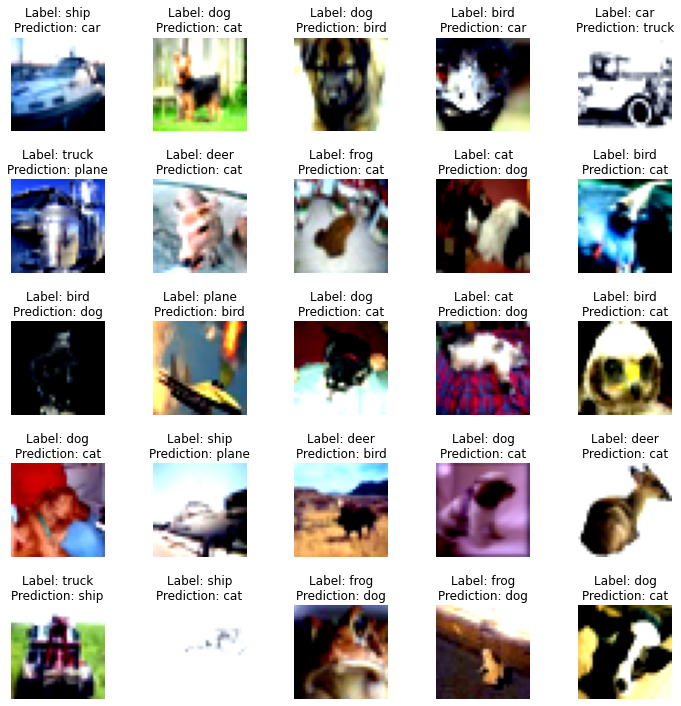

In [0]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.tight_layout()
i = 0
nrows = 5
ncols = 5
for row in range(nrows):
    for col in range(ncols):
        norm_image = utils.denormalize(incorrect_images[i].unsqueeze(dim=0),[0.5,0.5,0.5],[0.5,0.5,0.5])
        
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Label: {classes[incorrect_labels[i]]}\nPrediction: {classes[incorrect_predictions[i]]}')
        axs[row, col].imshow(np.transpose((norm_image.squeeze(dim=0).cpu().numpy()), (1, 2, 0)))
        i += 1

In [9]:
print(optimizer.param_groups[0]['lr'])

0.6554774436090226
